In [54]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pygal

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


from scipy.stats import ks_2samp

#pd.set_option("display.max_columns",200)

# Lectura de datos

In [55]:
filename='datos/train.csv'
df=pd.read_csv(filename)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Ingeniería de datos

In [56]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [57]:
varc=["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","TotalBsmtSF",
 "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","BsmtUnfSF","FullBath",
 "HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea",
 "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","MoSold",
 ]
tgt="SalePrice"
id_='Id'

## Análisis de exploratorio e ingenieria de datos

### Tratamiento de variables categoricas y fechas

A todas las variables que el diccionario indica que sus datos ausente representan en realidad
la ausencia de esa caracterisica los rellenamos con un valor en forma de string para poder trabajar con ellos.

En la variable MasVnr hay dos tipos de valores ausentes que significan lo mismo.

In [58]:
def remplazar_nan(df):    
    remp=["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
       "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence",
        "MiscFeature","MasVnrType"]
    for r in remp:
        df[r].fillna(value='No',inplace=True)
    df["MasVnrType"].replace({'None':'No'},inplace=True)

In [59]:
remplazar_nan(df)

Los valores 'YearBuilt', 'YearRemodAdd' los sustituiremos por su equivalente en antiguedad y
antiguedad de remodelación suponiendo que estamos en el 2011, pues la última venta fue
hecha en el 2010.

In [60]:
def antiguedad(df):
    df['Antiguedad']=2011-df["YearBuilt"]
    df["Antiguedad_rem"]=2011-df["YearRemodAdd"]
    df["Antig_Garage"]=2011-df["GarageYrBlt"]
    df.drop(["YearBuilt","YearRemodAdd","GarageYrBlt"],axis=1,inplace=True)

In [61]:
antiguedad(df)

In [62]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Antiguedad,Antiguedad_rem,Antig_Garage
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,...,No,0,2,2008,WD,Normal,208500,8,8,8.0
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,...,No,0,5,2007,WD,Normal,181500,35,35,35.0


In [63]:
varc=varc+["Antiguedad","Antiguedad_rem","Antig_Garage"]

Ahora vamos a crear una lista con las variables discretas.

In [64]:
vard=[]
for col in df.columns:
    if( (col not in varc) and col!=tgt and col != id_):
        vard.append(col)

In [65]:
len(vard)

47

### Valores ausentes categoricas y OneHotEncoder

Vemos que solo hay una variable con un dato ausente.

In [66]:
df[vard].shape,df[vard].dropna().shape

((1460, 47), (1459, 47))

In [67]:
df[["Electrical"]][df["Electrical"].isna() == True]

,Electrical
1379,NaN


In [68]:
df.drop(1379,axis=0,inplace=True)
df=df.reset_index(drop=True).copy()

Ahora convertiremos las variables discretas en continuas.

In [69]:
def codificar(data):
    aux = data[vard].copy()
    oh = OneHotEncoder()
    oh.fit(aux)
    X=pd.DataFrame(oh.transform(aux).toarray(),columns=oh.get_feature_names())
    return X.assign(Id=data[id_].values)

In [70]:
X=codificar(df)

In [71]:
len(X.columns)

305

In [72]:
len(vard)

47

### Valores ausentes continuas

Notamos que solo tres variables tienen datos ausentes, más aún, solo dos acaparán la gran mayoría de ellos.

In [73]:
aux=(1-(len(df)-df[varc].describe().T[['count']])/len(df))
aux[aux['count']<1]

,count
LotFrontage,0.822481
MasVnrArea,0.994517
Antig_Garage,0.944483


Esta variable la llenaremos con 0 por que las otras variables que tenian None estabán llenas con cero
indicando que no tienen esa area.

In [74]:
df['MasVnrArea'].fillna(value=0,inplace=True)

Para el caso de la antiguedad del Garage no podemos hacer esto, por que notamos que todos los ausentes se deben a que no hay garage, así que las posibilidades que tenemos son la imputación o bien eliminar las 81 filas.

In [75]:
df[df['GarageFinish']=='No']["Antig_Garage"]

39     NaN
48     NaN
78     NaN
88     NaN
89     NaN
        ..
1349   NaN
1406   NaN
1448   NaN
1449   NaN
1452   NaN
Name: Antig_Garage, Length: 81, dtype: float64

En el caso de LotFrontage no es claro a que se debe su ausencia por lo que recurriremos a la imputación.

In [76]:
aux=df[varc]
im = SimpleImputer(strategy='median')
im.fit(aux)
Xc = pd.DataFrame(im.transform(aux),columns=varc)

En la prueba de bondad de ajuste vemos que ninguna variable se rompió.

In [77]:
#Prueba de Kolmogorov-Smirnov (Prueba de bondad de ajuste que verifica que dos distribuciones son estadísticamente iguales)k
ks = pd.DataFrame(map(lambda v: (v,ks_2samp(aux[v].dropna(),Xc[v]).statistic),varc),columns=['variable','ks'])
ks.loc[ks['ks']>.1]

,variable,ks


In [78]:
Xc=Xc.assign(Id=df[id_].values)

In [79]:
tad = Xc.merge(X,on=id_,how='inner')

In [80]:
varcn=list(tad.columns)

In [81]:
varcn.remove(id_)

In [82]:
tad=tad.assign(SalePrice=df[tgt].values)

### Unarias

In [83]:
unarias = [v for v,n in [(v,tad[v].unique().shape[0]) for v in varc] if n ==1 ]
unarias

[]

### Valores extremos

Solo verificaremos los valores extremos para las variables continuas originales y no las convertidas, pues estas tienen solo valores de 0 o 1 y es fácil caer en que ciertos valores extremos lo son cuando en la realidad no sucede.

In [84]:
varcd=[v for v in varcn if v not in varc]
len(varcd)

304

In [85]:
limites=tad[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

In [86]:
for v,li,ls in limites:
    tad['ol_{}'.format(v)]= ((tad[v]<li)|(tad[v]>ls)).astype(int)

In [87]:
varo = [v for v in tad.columns if v[:2]=='ol']
len(varo)

32

In [88]:
#Captura las filas con valores extremos
tad['ext'] = tad[varo].max(axis=1)

Vemos que son demasiadas filas como para borrarlas, buscaremos ver que sucede con las columnas.

In [89]:
tad['ext'].sum()

266

Notamos que la gran mayoría de variables tienen outliers.

<AxesSubplot:>

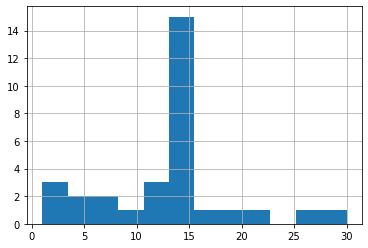

In [90]:
s=tad[varo].sum()
s[s>0].hist(bins=12)

In [91]:
tad.drop(varo,axis=1,inplace=True)

Al final si se decide borrar todas esas filas.

In [92]:
tad.drop(list(tad[tad['ext']==1].index),axis=0,inplace=True)
tad=tad.reset_index(drop=True).copy()

In [93]:
tad.drop(['ext'],axis=1,inplace=True)

In [94]:
tad[[id_]+[tgt]]

,Id,SalePrice
0,1,208500
1,2,181500
2,3,223500
3,5,250000
4,7,307000
...,...,...
1188,1453,145000
1189,1454,84500
1190,1455,185000
1191,1456,175000


### Reducción de caracteristicas

In [235]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [237]:
X=tad[varcn]
y=tad[tgt]

In [254]:
pi = make_pipeline(PCA(n_components=10),MinMaxScaler())

In [255]:
Xp = pd.DataFrame(pi.fit_transform(X))

In [256]:
pi.steps[0][-1].explained_variance_ratio_.cumsum()

array([0.9384369 , 0.95795585, 0.97639528, 0.99201251, 0.9946074 ,
       0.99619435, 0.99738589, 0.99834406, 0.99903767, 0.99940357])

In [257]:
Xp

,0,1,2,3,4,5,6,7,8,9
0,0.195565,0.458883,0.334208,0.716235,0.112372,0.426996,0.243976,0.383719,0.257902,0.078885
1,0.228565,0.381689,0.702565,0.554372,0.140843,0.525737,0.293380,0.231601,0.717581,0.040659
2,0.275885,0.502703,0.292069,0.603706,0.111210,0.402455,0.247651,0.332845,0.262443,0.077736
3,0.363159,0.599431,0.320462,0.699481,0.118083,0.293015,0.249615,0.456520,0.463500,0.068535
4,0.243829,0.512785,0.890521,0.701103,0.181352,0.507119,0.274384,0.319383,0.581531,0.063157
...,...,...,...,...,...,...,...,...,...,...
1188,0.057724,0.318172,0.529693,0.551294,0.350498,0.336871,0.172847,0.312248,0.349831,0.050296
1189,0.445828,0.404685,0.431848,0.077474,0.111830,0.812786,0.288257,0.395563,0.422698,0.056399
1190,0.168014,0.488700,0.614534,0.350648,0.156393,0.541949,0.272523,0.234918,0.328935,0.077554
1191,0.179995,0.596438,0.290673,0.391137,0.137108,0.500744,0.291421,0.211331,0.327828,0.077162


# Modelos

## Regresion lineal

In [258]:
Xt,Xv,yt,yv = train_test_split(Xp,y,train_size=0.7)

In [259]:
modeloRL = LinearRegression()

In [260]:
hiperparametros=dict(fit_intercept=[True,False],normalize=[True,False])
hiperparametros

{'fit_intercept': [True, False], 'normalize': [True, False]}

In [261]:
grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=modeloRL,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)

In [262]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:   11.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.7s finished


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=True)

In [263]:
modeloRL = grid.best_estimator_

In [264]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [265]:
modeloRL.fit(Xt,yt)

LinearRegression()

In [266]:
print(mean_absolute_error(y_true=yt,y_pred=modeloRL.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=modeloRL.predict(Xv)))

22650.123959045897
24868.35939083922


In [121]:
modeloRL.score(Xt,yt),modeloRL.score(Xv,yv)

(0.9470218602027461, 0.8784715186392913)

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

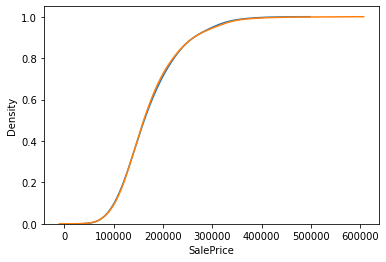

In [105]:
sns.distplot(modeloRL.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

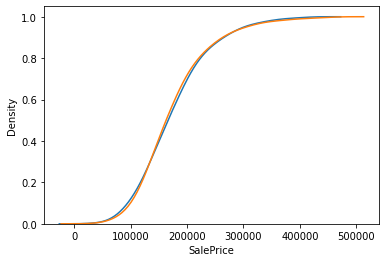

In [106]:
sns.distplot(modeloRL.predict(Xv),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

In [109]:
len(Xt),len(yt)

(835, 835)

## Regresion polinomial

In [107]:
from sklearn.preprocessing import PolynomialFeatures

In [118]:
poli_reg = PolynomialFeatures(degree=2)

In [119]:
Xt_poli=poli_reg.fit_transform(Xt)
Xv_poli=poli_reg.fit_transform(Xv)

In [110]:
len(Xt_poli)

835

In [111]:
modeloRLP=LinearRegression()

In [ ]:
grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=modeloRLP,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)

In [ ]:
#grid.fit(Xt_poli,yt)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
#grid.best_params

In [ ]:
#modeloRLP=grid.best_estimator

In [112]:
modeloRLP.fit(Xt_poli,yt)

LinearRegression()

In [114]:
print(mean_absolute_error(y_true=yt,y_pred=modeloRLP.predict(Xt_poli)))
print(mean_absolute_error(y_true=yv,y_pred=modeloRLP.predict(Xv_poli)))

5.358267013641621e-07
38361.84219700767


In [173]:
modeloRLP.score(Xt_poli,yt),modeloRLP.score(Xv_poli,yv)

(1.0, 0.30425273096636396)

## Maquina de soporte vectorial 

In [122]:
from sklearn.svm import SVR

In [131]:
svr=SVR()

In [155]:
hiperparametros=dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'],
                    C=list(np.arange(0.0, 1.0, 0.5)),
                    epsilon=list(np.arange(0.0, 1.0, 0.4)))
hiperparametros

{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'C': [0.0, 0.5],
 'epsilon': [0.0, 0.4, 0.8]}

In [156]:
grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=svr,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)

In [157]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.4min finished


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.0, 0.5], 'epsilon': [0.0, 0.4, 0.8],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_absolute_error', verbose=True)

In [159]:
grid.best_params_

{'C': 0.5, 'epsilon': 0.8, 'kernel': 'linear'}

In [158]:
svr=grid.best_estimator_

In [160]:
svr.fit(Xt,yt)

SVR(C=0.5, epsilon=0.8, kernel='linear')

In [161]:
print(mean_absolute_error(y_true=yt,y_pred=svr.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=svr.predict(Xv)))

18246.270633336047
20673.746581692576


In [172]:
svr.score(Xt,yt),svr.score(Xv,yv)

(0.8117074663483524, 0.7792026384735925)

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

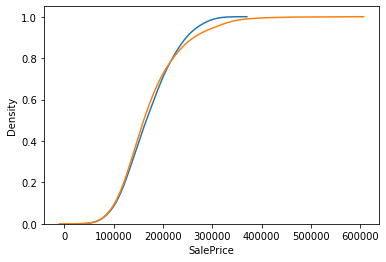

In [162]:
sns.distplot(svr.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

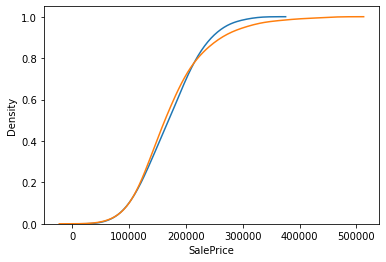

In [163]:
sns.distplot(svr.predict(Xv),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

## Arbol de desición

In [164]:
from sklearn.tree import DecisionTreeRegressor

In [174]:
help(arbol)

Help on DecisionTreeRegressor in module sklearn.tree._classes object:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(*, criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"mse", "friedman_mse", "mae"}, default="mse"
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion and minimizes the L2 loss
 |      using the mean of each terminal node, "friedman_mse", which uses mean
 |      squared error with Friedman's improvement score for potential 

In [199]:
arbol=DecisionTreeRegressor(splitter='random',max_depth=10)

In [200]:
arbol.fit(Xt,yt)

DecisionTreeRegressor(max_depth=10, splitter='random')

In [201]:
print(mean_absolute_error(y_true=yt,y_pred=arbol.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=arbol.predict(Xv)))

7305.433226805594
22924.490558641148


In [202]:
arbol.score(Xt,yt),arbol.score(Xv,yv)

(0.9663178622063007, 0.734775851808857)

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

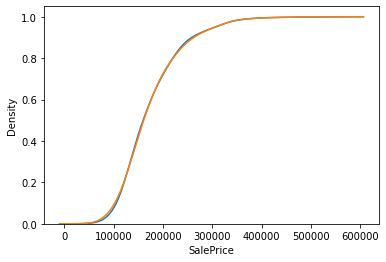

In [203]:
sns.distplot(arbol.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

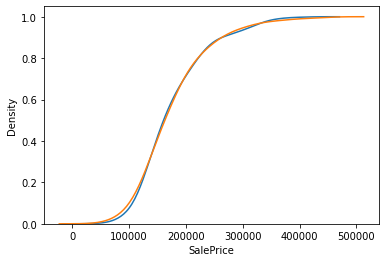

In [204]:
sns.distplot(arbol.predict(Xv),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

## Bosques aleatorios

In [206]:
from sklearn.ensemble import RandomForestRegressor

In [207]:
bosque=RandomForestRegressor()

In [232]:
help(bosque)

Help on RandomForestRegressor in module sklearn.ensemble._forest object:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ---------

In [208]:
bosque.fit(Xt,yt)

RandomForestRegressor()

In [211]:
print(mean_absolute_error(y_true=yt,y_pred=bosque.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=bosque.predict(Xv)))

5885.542862275449
16147.754888268157


In [210]:
bosque.score(Xt,yt),bosque.score(Xv,yv)

(0.9799715013840982, 0.8676281795101822)

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

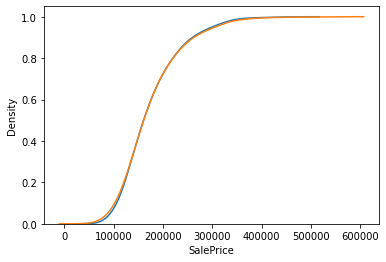

In [212]:
sns.distplot(bosque.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

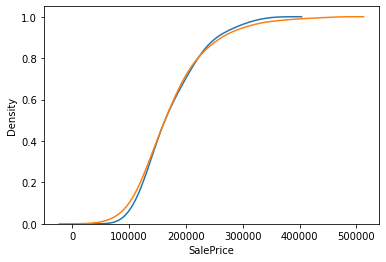

In [213]:
sns.distplot(bosque.predict(Xv),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

# Test

In [214]:
filetest='datos/test.csv'
test=pd.read_csv(filetest)
len(test)

1459

In [215]:
remplazar_nan(test)

In [216]:
antiguedad(test)

Para no perder datos trataremos estos valores ausentes como una categoria más, la categoria 'No', pero que
ignoraremos para conteos finales.

In [217]:
def ausentes_fc(df):
    mis=[]
    mis_c=[]
    for col in df.columns:
        l=list(df[df[col].isna()].index)
        if(l != [] ):
            mis_c.append(col)    
            mis+=l
    fil_mis=list(dict.fromkeys(mis))
    return sorted(fil_mis),mis_c
ausentes_fc(test[vard])

([95, 455, 485, 691, 756, 790, 1013, 1029, 1444],
 ['MSZoning',
  'Utilities',
  'Exterior1st',
  'Exterior2nd',
  'KitchenQual',
  'Functional',
  'SaleType'])

In [218]:
t_d=test[vard+[id_]].fillna(value='No')

In [219]:
X=codificar(t_d)
len(X.columns)

295

In [220]:
col=[]
for i in varcd:
    if i not in X.columns:
        col.append(i)      
col,len(col)

(['x6_NoSeWa',
  'x11_RRAe',
  'x11_RRAn',
  'x11_RRNn',
  'x13_2.5Fin',
  'x17_ClyTile',
  'x17_Membran',
  'x17_Metal',
  'x17_Roll',
  'x18_ImStucc',
  'x18_Stone',
  'x19_Other',
  'x29_Floor',
  'x29_OthW',
  'x32_Mix',
  'x38_Ex',
  'x41_Fa',
  'x43_TenC'],
 18)

Completamos las columnas faltantes con ceros por que si no esán quiere decir que esa caracteristica no se encuentra y está bien rellenar con ceros.

In [221]:
X[col]=np.zeros((len(t_d),len(col)), dtype=int)

Ahora las columnas son más de lo esperado pero es normal por que añadimos ficticiamente 7 valores con un 'No' y por ello en lugar de ser 306 son 3013 variables.

In [222]:
len(X.columns)

313

En las variables continuas nos encontramos con grandes cantidades de datos ausentes, en una situación común ignorariamos estos datos, pero como la competencia exige que todas las filas tengan una predicción haremos la imputación de estos datos.

In [223]:
filas,cols =ausentes_fc(test[varc])
len(filas),cols

(313,
 ['LotFrontage',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'TotalBsmtSF',
  'BsmtFullBath',
  'BsmtHalfBath',
  'BsmtUnfSF',
  'GarageCars',
  'GarageArea',
  'Antig_Garage'])

In [224]:
aux=test[varc]
im = SimpleImputer(strategy='median')
im.fit(aux)
Xtc = pd.DataFrame(im.transform(aux),columns=varc)
Xtc=Xtc.assign(Id=test[id_].values)

In [225]:
tad_test=X.merge(Xtc,on=id_,how='inner')

In [226]:
Xi=tad_test[varcn]

In [ ]:
len(Xi)

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

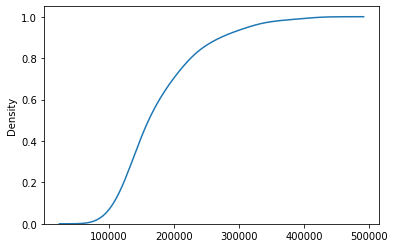

In [227]:
sns.distplot(bosque.predict(Xi),hist=False,kde_kws={'cumulative':True})

In [228]:
prediccion=pd.DataFrame(bosque.predict(Xi))
prediccion.head()

,0
0,126646.50
1,151766.00
2,189916.00
3,183632.98
4,198633.20


In [229]:
prediccion=prediccion.assign(Id=test[id_].values)
prediccion.head()

,0,Id
0,126646.50,1461
1,151766.00,1462
2,189916.00,1463
3,183632.98,1464
4,198633.20,1465


In [230]:
prediccion.columns=['SalePrice','Id']
prediccion=prediccion[['Id','SalePrice']]
prediccion.head()

,Id,SalePrice
0,1461,126646.50
1,1462,151766.00
2,1463,189916.00
3,1464,183632.98
4,1465,198633.20


In [231]:
prediccion.to_csv("datos/submission.csv",index=False)